In [1]:
import gym.envs.toy_text.frozen_lake as frozen_lake # I guess `toy_text` is a separate package?
from gym import make
import gym
from gym.envs.registration import register, registry
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import myenv
from pprint import pprint
import warnings
import xlrd
import time
import matplotlib.mlab as mlab
from matplotlib import colors

In [2]:
# These are the non-random maps
MAPS = {
    "4x4": [
        "SFFF",
        "FHFH",
        "FFFH",
        "HFFG"
    ],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG"
    ],
    "16x16" : [
        'SFFFFFHHFFFFFFFF',
        'FFFFHFFHFFFFFFHF',
        'FHFFFFFHFHFHFFFF',
        'HFFHFFFFFFFFFHFH',
        'FHFFFFHHFFFHHFHF',
        'FHFFHFHFFFFHFFFF',
        'FFHFFFFHFFFHHHHF',
        'HFHFFFFFFFFFFFFH',
        'FFFFFFFFFHFFFFHF',
        'FFFFFFHHFHFFFFFH',
        'FFHFFFFFFHFFFHFF',
        'FFFHHFHFFFFFHFFF',
        'FFFFFHFHFFFFHFFF',
        'HHHHHFFFHFFHFFFF',
        'FHFFHFFFFFFFFFFF',
        'FFHFHHFFHFFFFFFG'
    ]
}

In [3]:
def sixteen_by_sixteen_map():
    return frozen_lake.generate_random_map(size=16)

In [4]:
# ##
# Utility Functions
# ##

def getStateReward(env):
    n_states = env.observation_space.n
    Rs = np.empty(n_states)
    Rs.fill(np.nan)
    p = env.P
    for state in p:
        for action_commanded in p[state]:
            for action_possible in p[state][action_commanded]:
                Rs[action_possible[1]] = action_possible[2]
    
    return Rs 

In [5]:
def getReward(env):
    n_states, n_actions = env.observation_space.n, env.action_space.n
    
    R = np.zeros((n_states, n_actions))
    for s in range(n_states):
        for a, moves in env.P[s].items():
            for possible_move in moves:
                prob, _, r, _ = possible_move
                R[s, a] += r * prob
    
    return R

def getProb(env):
    n_states, n_actions = env.observation_space.n, env.action_space.n
    
    P = np.zeros((n_states, n_actions, n_states))
    for s in range(n_states):
        for a in range(n_actions):
            for moves in env.P[s][a]:
                prob, next_s, _, _ = moves
                P[s, a, next_s] += prob
    
    return P

def print_value(V, width=4, height=4):
    return np.around(np.resize(V, (width, height)), 4)

# https://gist.github.com/braingineer/d801735dac07ff3ac4d746e1f218ab75
# matprint.py Pretty print a matrix in Python 3 with numpy
def matprint(mat, fmt="g"):
    if mat[0][0] in ["←", "↓", "→", "↑"]:
        fmt = 's'# fmt='s' for arrows
    if mat[0][0] in [b'S', b'F', b'H', b'G']:
        fmt = 's'
        mat = mat.astype('<U8')
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

In [6]:
# let's plot the policy matrix (as in Part 1). according to
# https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py
# LEFT = 0   DOWN = 1   RIGHT = 2  UP = 3
def print_policy(V, width=4, height=4):
    table = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    policy = np.resize(V, (width, height))
    
    # transform using the dictionary
    return np.vectorize(table.get)(policy)

In [7]:
# ##
# Generate a Customized Frozen Lake
# ##

def getEnv(env_id='default', rH=0, rG=1, rF=0, desc=None, map_name='4x4', is_slippery=True, render_initial=True):

    if env_id in gym.envs.registry.env_specs:
        del gym.envs.registry.env_specs[env_id]

    register(
        id=env_id, # name given to this new environment
        entry_point='myenv:CustomizedFrozenLake', # env entry point
        kwargs={'rH': rH, 'rG': rG, 'rF': rF, 
                'desc': desc,
                'map_name': map_name, 
                'is_slippery': is_slippery} # argument passed to the env
    )

    this_env = make(env_id)

    if render_initial:
        print('--Board--')
        this_env.render()
        print('\n--Actions for Position to the Left of the Goal--')
        pprint(this_env.P[this_env.nS - 2])
    
    return this_env

In [8]:
#Default settings, uncomment to just use these
settings = {'rH': [-1],
 'rG': [1],
 'rF': [-0.2],
 'size': [16],
 'p': [0.8],
 'is_slippery': [False],
 'render_initial': [True],
 'epsilon': [1e-08],
 'gamma': [0.8],
 'max_iter': [10000],
 'qepsilon': [0.1],
 'lr': [0.8],
 'qgamma': [0.95],
 'episodes': [10000],
 'initial': [1],
 'decay': [True],
 'report': [True],
 'display_print': [True]}

In [9]:
# Determine the number of runs
n_settings = len(settings['rH'])
print(n_settings)

1


In [10]:
n=0
# Load settings
rH = settings['rH'][n] # -1 #-5 # reward for H(ole)
rG = settings['rG'][n] #1 # 10 # reward for G(oal)
rF = settings['rF'][n] #-0.2# reward includes S(tart) and F(rozen)
size = settings['size'][n] #4 # height and width of square gridworld, [4, 8, 16] are included in cs7641assn4.py 
p = settings['p'][n] #0.8 # if generating a random map probability that a grid will be F(rozen)
map_name = 'x'.join([str(size)]*2) # None, if you want a random map
desc = MAPS[map_name] # None, if you want a random map
is_slippery = settings['is_slippery'][n] #False
render_initial = settings['render_initial'][n] # True

epsilon = settings['epsilon'][n] #1e-8 # convergence threshold for policy/value iteration
gamma = settings['gamma'][n] #0.8 # discount parameter for past policy/value iterations
max_iter = settings['max_iter'][n] #10000 # maximum iterations for slowly converging policy/value iteration 

# Qlearning(env, rH=0, rG=1, rF=0, qepsilon=0.1, lr=0.8, gamma=0.95, episodes=10000)
qepsilon = settings['qepsilon'][n] #0.1 # epsilon value for the Q-learning epsilon greedy strategy
lr = settings['lr'][n] #0.8 # Q-learning rate
qgamma = settings['qgamma'][n] #0.95 # Q-Learning discount factor
episodes = settings['episodes'][n] #10000 # number of Q-learning episodes
initial = settings['initial'][n] #0 # value to initialize the Q grid
decay = settings['decay'][n] #True

# Printing options
report = settings['report'][n] #True # For cs7641assn4.py policy and value iteration functions
display_print = settings['display_print'][n] #True # For this script

# Create Environment
env = getEnv(env_id='hw4-FrozenLake-v0', rH=rH, rG=rG, rF=rF, 
                desc=desc,  
                is_slippery=is_slippery, render_initial=True)

# Store a representation of the map
env_desc = env.desc.astype('<U8')

# Store a representation of the state rewards
env_rs = getStateReward(env)

if display_print:
    # Display reward at each state
    print('\n--Reward Values at Each State--')
    matprint(print_value(env_rs, width=size, height=size))

--Board--

SFFFFFHHFFFFFFFF
FFFFHFFHFFFFFFHF
FHFFFFFHFHFHFFFF
HFFHFFFFFFFFFHFH
FHFFFFHHFFFHHFHF
FHFFHFHFFFFHFFFF
FFHFFFFHFFFHHHHF
HFHFFFFFFFFFFFFH
FFFFFFFFFHFFFFHF
FFFFFFHHFHFFFFFH
FFHFFFFFFHFFFHFF
FFFHHFHFFFFFHFFF
FFFFFHFHFFFFHFFF
HHHHHFFFHFFHFFFF
FHFFHFFFFFFFFFFF
FFHFHHFFHFFFFFFG

--Actions for Position to the Left of the Goal--
{0: [(1.0, 253, -0.2, False)],
 1: [(1.0, 254, -0.2, False)],
 2: [(1.0, 255, 1, True)],
 3: [(1.0, 238, -0.2, False)]}

--Reward Values at Each State--
-0.2  -0.2  -0.2  -0.2  -0.2  -0.2    -1    -1  -0.2  -0.2  -0.2  -0.2  -0.2  -0.2  -0.2  -0.2  
-0.2  -0.2  -0.2  -0.2    -1  -0.2  -0.2    -1  -0.2  -0.2  -0.2  -0.2  -0.2  -0.2    -1  -0.2  
-0.2    -1  -0.2  -0.2  -0.2  -0.2  -0.2    -1  -0.2    -1  -0.2    -1  -0.2  -0.2  -0.2  -0.2  
  -1  -0.2  -0.2    -1  -0.2  -0.2  -0.2  -0.2  -0.2  -0.2  -0.2  -0.2  -0.2    -1  -0.2    -1  
-0.2    -1  -0.2  -0.2  -0.2  -0.2    -1    -1  -0.2  -0.2  -0.2    -1    -1  -0.2    -1  -0.2  
-0.2    -1  -0.2  -0.2    -1 

In [11]:
def evaluate_policy(env, policy, err=[], t=[], gamma=0.9, theta=0.00001, render=False):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    #err=[]
    #k=[]
    #t=[]
    i=0
    V = np.zeros(env.unwrapped.nS)
    while True:
        delta = 0
        start=time.time()
        # For each state, perform a "full backup"
        for s in range(env.unwrapped.nS):
            vs = 0
            # Look at the possible next actions
            for a, action_prob in enumerate(policy[s]):
                # For each action, look at the possible next states...
                for  prob, next_state, reward, done in env.P[s][a]:
                    # Calculate the expected value
                    #
                    vs +=  action_prob * prob * (reward + gamma * V[next_state])
            # How much our value function changed (across any states)
            delta = max(delta, np.abs(vs - V[s]))
            V[s] = vs
        end=time.time()    
        ti=end-start
        t.append(ti)
        #print(t)
        err.append(delta)
        #k.append(i)
        i=i+1
        # Stop evaluating once our value function change is below a threshold
        if delta < theta:
            break
    return np.array(V)

In [12]:
def policy_improvement(env, V, policy, gamma=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI environment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """

    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[state][a]:
                A[a] += prob * (reward + gamma * V[next_state])
        return A
    
    
    # Will be set to false if we make any changes to the policy
    policy_stable = True
        
    # For each state...
    for s in range(env.nS):
        # The best action we would take under the current policy
        chosen_a = np.argmax(policy[s])
            
        # Find the best action by one-step lookahead
        # Ties are resolved arbitarily
        action_values = one_step_lookahead(s, V)
        best_a = np.argmax(action_values)
            
        # Greedily update the policy
        if chosen_a != best_a:
            policy_stable = False
        policy[s] = np.eye(env.nA)[best_a]
        
    # If the policy is stable we've found an optimal policy. Return it
    return policy_stable

In [13]:
def policy_iteration(env, theta=1e-20, gamma=0.9, render=False):
    # Start with a random policy
    policy = np.ones([env.unwrapped.nS, env.unwrapped.nA]) / env.unwrapped.nA
    score=[]
    #i = 0
    #t=[]
    #err=[]
    totaltime=0
    while True:
        t=[]
        err=[]
        V = evaluate_policy(env, policy, err, t, gamma, theta)
        score.append(np.mean(V))
        totaltime+=np.sum(t)
        if render == True:
            print('value iteration for this policy improvement is ', len(err))
            err=np.array(err)
            #kp=np.array(kp)
            t=np.array(t)
            
            plt.figure(figsize=[15,6])
            plt.subplot(1,2,1)
            line1, = plt.plot(err,color='r',label='error')
            plt.ylabel('error')
            plt.xlabel('iteration')
            plt.subplot(1,2,2)
            line2,=plt.plot(t,color='g',label='time')
            #plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
            plt.ylabel('time')
            plt.xlabel('iteration')
            plt.show()
        #print(t)
        #print(err)
        #print(kp)
        #i = i+1
        if policy_improvement(env, V, policy, gamma):
            #print ('Policy-iteration converged at iteration# %d.' %(i))
            
            break
    return policy, V, totaltime

### To evaluate the policy, as there is no max in the equation, we can just solve the linear system since the previous policy evaluation and improvement needs too long time to get converged

In [14]:
def policy_evaluation1(pi, P, R, gamma, n_states):
    p = np.zeros((n_states, n_states))
    r = np.zeros((n_states, 1))
    
    for s in range(n_states):
        r[s] = R[s, pi[s]]
        p[s, :] = P[s, pi[s], :]
    
    # we take [:, 0] to return a vector because otherwise we have
    # a matrix of size (# states, 1)
    return np.linalg.inv((np.eye(n_states) - gamma * p)).dot(r)[:, 0]

def policy_iteration1(env, epsilon=1e-8, gamma=0.8, max_iter=10000, report=False):
    n_states = env.observation_space.n
    
    # initialize arbitrary value function
    V = np.zeros(n_states)
    
    # initialize arbitrary policy
    pi = np.ones(n_states, dtype=int)
    
    R = getReward(env)
    P = getProb(env)
    
    i = 0
    t=[]
    err=[]
    totaltime=0
    while True and i < max_iter:
        
        V_prev = V.copy()
        start=time.time()
        # evaluate the policy
        V = policy_evaluation1(pi, P, R, gamma, n_states)
        
        # policy improvement
        for s in range(n_states):
            pi[s] = np.argmax(R[s,:] + gamma * P[s, :, :].dot(V)) 
        delta = np.linalg.norm(V_prev - V)
        end=time.time()    
        ti=end-start
        t.append(ti)
        err.append(delta)
        if  delta < epsilon:
            
            totaltime+=np.sum(t)
            if report:
                err=np.array(err)
                #kp=np.array(kp)
                t=np.array(t)
                print("Policy iteration converged after ", i+1, "epochs")
                plt.figure(figsize=[15,6])
                plt.subplot(1,2,1)
                line1, = plt.plot(err,color='r',label='error')
                plt.ylabel('error')
                plt.xlabel('iteration')
                plt.subplot(1,2,2)
                line2,=plt.plot(t,color='g',label='time')
                #plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
                plt.ylabel('time')
                plt.xlabel('iteration')
                plt.show()
            break
        
        i += 1
    
    return pi, V, totaltime

In [15]:
def extract_policy(v, gamma = 1.0):
    """ Extract the policy given a value-function """
    policy = np.zeros(env.nS)
    for s in range(env.nS):
        q_sa = np.zeros(env.action_space.n)
        for a in range(env.action_space.n):
            for next_sr in env.P[s][a]:
                # next_sr is a tuple of (probability, next state, reward, done)
                p, s_, r, _ = next_sr
                q_sa[a] += (p * (r + gamma * v[s_]))
        policy[s] = np.argmax(q_sa)
    return policy

In [16]:
def play_policy(env, policy, render=False):
    total_reward=0.
    observation = env.reset()
    while True:
        if render:
            env.render()
        action = np.random.choice(env.action_space.n, p=policy[observation])
        observation,reward,done,_ = env.step(action)
        total_reward += reward
        if done:
            break
    return total_reward

Policy iteration converged after  20 epochs


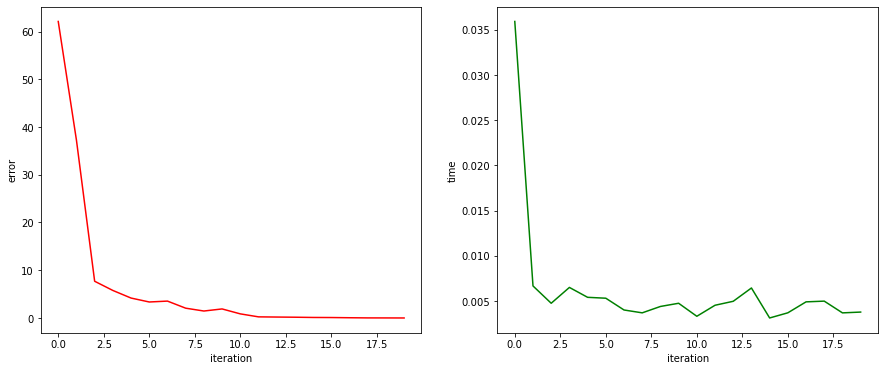

In [17]:
policy, V, _ = policy_iteration1(env,epsilon=epsilon, gamma=gamma, max_iter=max_iter, report=True)

In [18]:
policy

array([2, 1, 1, 1, 2, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 2, 2, 2, 1, 0, 1,
       1, 0, 1, 2, 1, 0, 0, 0, 0, 1, 3, 0, 2, 2, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 2, 1, 0, 1, 1, 2, 2, 2, 1, 1, 0, 0, 0, 3, 0, 1, 0,
       1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 2, 1, 0, 1, 0, 2,
       1, 1, 1, 0, 2, 0, 0, 0, 2, 1, 0, 1, 1, 1, 1, 0, 2, 1, 1, 0, 0, 0,
       0, 2, 0, 1, 0, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 2, 2, 1, 0, 1, 1, 2, 1, 0, 2, 2, 2, 2, 1, 1, 1, 0, 0, 1, 0,
       1, 2, 2, 2, 1, 0, 2, 3, 0, 2, 2, 2, 2, 1, 1, 0, 1, 1, 3, 0, 1, 1,
       2, 3, 0, 0, 0, 3, 0, 2, 1, 1, 1, 1, 0, 1, 1, 1, 2, 3, 0, 0, 0, 0,
       1, 0, 2, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 2, 2, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 2, 0, 0, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 2, 3, 0, 2, 2, 2, 2, 2, 2, 0])

In [19]:
V

array([-0.99071545, -0.98839431, -0.98549289, -0.98186611, -0.97733264,
       -0.9716658 , -5.        , -5.        , -0.94465977, -0.93082471,
       -0.91353089, -0.93082471, -0.94465977, -0.95572781, -0.96458225,
       -0.9716658 , -0.98839431, -0.98549289, -0.98186611, -0.97733264,
       -5.        , -0.96458225, -0.95572781, -5.        , -0.93082471,
       -0.91353089, -0.89191361, -0.91353089, -0.93082471, -0.94465977,
       -5.        , -0.96458225, -0.99071545, -5.        , -0.97733264,
       -0.9716658 , -0.96458225, -0.95572781, -0.94465977, -5.        ,
       -0.91353089, -5.        , -0.86489201, -5.        , -0.91353089,
       -0.93082471, -0.94465977, -0.95572781, -5.        , -0.97733264,
       -0.9716658 , -5.        , -0.95572781, -0.94465977, -0.93082471,
       -0.91353089, -0.89191361, -0.86489201, -0.83111501, -0.86489201,
       -0.89191361, -5.        , -0.95572781, -5.        , -0.97733264,
       -5.        , -0.96458225, -0.95572781, -0.94465977, -0.93

In [20]:
policy1 = extract_policy(V,gamma=gamma)
len(policy1)

256

In [21]:
policy1

array([2., 1., 1., 1., 2., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 2.,
       2., 2., 1., 0., 1., 1., 0., 1., 2., 1., 0., 0., 0., 0., 1., 3., 0.,
       2., 2., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 2., 1.,
       0., 1., 1., 2., 2., 2., 1., 1., 0., 0., 0., 3., 0., 1., 0., 1., 2.,
       2., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 2., 1., 0.,
       1., 0., 2., 1., 1., 1., 0., 2., 0., 0., 0., 2., 1., 0., 1., 1., 1.,
       1., 0., 2., 1., 1., 0., 0., 0., 0., 2., 0., 1., 0., 2., 1., 1., 1.,
       1., 2., 2., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 2., 2.,
       1., 0., 1., 1., 2., 1., 0., 2., 2., 2., 2., 1., 1., 1., 0., 0., 1.,
       0., 1., 2., 2., 2., 1., 0., 2., 3., 0., 2., 2., 2., 2., 1., 1., 0.,
       1., 1., 3., 0., 1., 1., 2., 3., 0., 0., 0., 3., 0., 2., 1., 1., 1.,
       1., 0., 1., 1., 1., 2., 3., 0., 0., 0., 0., 1., 0., 2., 1., 1., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 2., 2., 1., 0., 1., 1., 0., 1.,
       1., 1., 1., 0., 0.

In [22]:
ps=[]
pscha=[]
for elem in policy1:
    ps.append(elem)
    if elem==1.0:
        pscha.append('D')
    elif elem==2.0:
        pscha.append('R')
    elif elem==0.0:
        pscha.append('L')
    else:
        pscha.append('U')

reshaped_policy=np.reshape(pscha,(16,16))
print(reshaped_policy)
#print(tabulate(reshaped_policy,tablefmt='latex'))

[['R' 'D' 'D' 'D' 'R' 'D' 'L' 'L' 'D' 'D' 'D' 'D' 'L' 'L' 'L' 'D']
 ['R' 'R' 'R' 'D' 'L' 'D' 'D' 'L' 'D' 'R' 'D' 'L' 'L' 'L' 'L' 'D']
 ['U' 'L' 'R' 'R' 'D' 'D' 'D' 'L' 'D' 'L' 'D' 'L' 'D' 'L' 'L' 'L']
 ['L' 'R' 'D' 'L' 'D' 'D' 'R' 'R' 'R' 'D' 'D' 'L' 'L' 'L' 'U' 'L']
 ['D' 'L' 'D' 'R' 'R' 'D' 'L' 'L' 'D' 'D' 'D' 'L' 'L' 'D' 'L' 'D']
 ['D' 'L' 'R' 'D' 'L' 'D' 'L' 'R' 'D' 'D' 'D' 'L' 'R' 'L' 'L' 'L']
 ['R' 'D' 'L' 'D' 'D' 'D' 'D' 'L' 'R' 'D' 'D' 'L' 'L' 'L' 'L' 'R']
 ['L' 'D' 'L' 'R' 'D' 'D' 'D' 'D' 'R' 'R' 'D' 'D' 'D' 'D' 'L' 'L']
 ['D' 'D' 'D' 'D' 'D' 'D' 'R' 'R' 'D' 'L' 'D' 'D' 'R' 'D' 'L' 'R']
 ['R' 'R' 'R' 'D' 'D' 'D' 'L' 'L' 'D' 'L' 'D' 'R' 'R' 'R' 'D' 'L']
 ['R' 'U' 'L' 'R' 'R' 'R' 'R' 'D' 'D' 'L' 'D' 'D' 'U' 'L' 'D' 'D']
 ['R' 'U' 'L' 'L' 'L' 'U' 'L' 'R' 'D' 'D' 'D' 'D' 'L' 'D' 'D' 'D']
 ['R' 'U' 'L' 'L' 'L' 'L' 'D' 'L' 'R' 'D' 'D' 'L' 'L' 'D' 'D' 'D']
 ['L' 'L' 'L' 'L' 'L' 'R' 'R' 'D' 'L' 'D' 'D' 'L' 'D' 'D' 'D' 'D']
 ['L' 'L' 'R' 'L' 'L' 'R' 'R' 'R' 'R' 'D' 'D' 'D' 'R' 'D' 'D' 

In [23]:
data=np.ones([16,16])*20
data[15,2]=7
data[15,4]=7
data[15,5]=7
data[15,8]=7
data[14,1]=7
data[14,4]=7
data[13,0]=7
data[13,1]=7
data[13,2]=7
data[13,3]=7
data[13,4]=7
data[13,8]=7
data[13,11]=7
data[12,5]=7
data[12,7]=7
data[12,12]=7
data[11,3]=7
data[11,4]=7
data[11,6]=7
data[11,12]=7
data[10,2]=7
data[10,9]=7
data[10,14]=7
data[9,6]=7
data[9,7]=7
data[9,9]=7
data[9,15]=7
data[8,9]=7
data[8,14]=7
data[7,0]=7
data[7,1]=7
data[7,15]=7
data[6,2]=7
data[6,7]=7
data[6,11]=7
data[6,12]=7
data[6,13]=7
data[6,14]=7
data[5,1]=7
data[5,4]=7
data[5,6]=7
data[5,11]=7
data[0,0]=10
data[0,6]=7
data[0,7]=7
data[1,4]=7
data[1,7]=7
data[2,1]=7
data[2,7]=7
data[2,9]=7
data[2,11]=7
data[3,0]=7
data[3,3]=7
data[3,13]=7
data[3,15]=7
data[4,1]=7
data[4,6]=7
data[4,7]=7
data[4,11]=7
data[4,12]=7
data[4,14]=7
data[15,15]=0

In [24]:
# create discrete colormap
cmap = colors.ListedColormap(['green', 'red','orange','blue'])
bounds = [0,5,10,15,20]
norm = colors.BoundaryNorm(bounds, cmap.N)

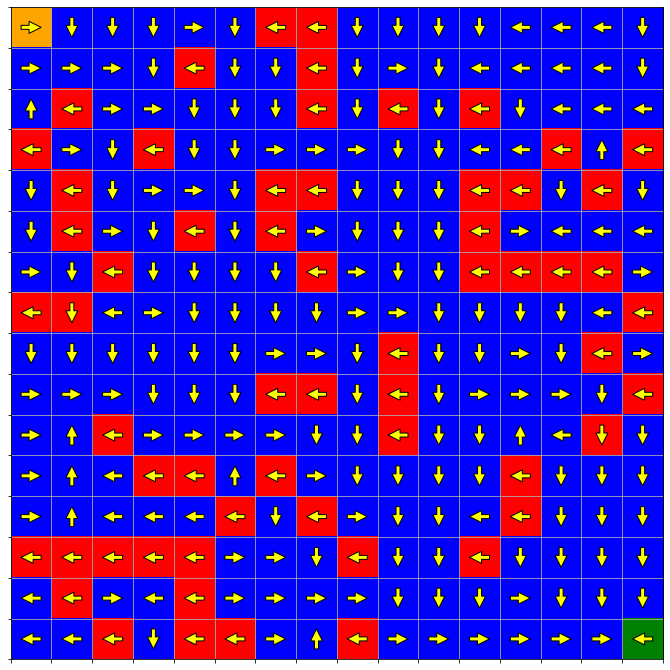

In [25]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(data, cmap=cmap)

# draw gridlines
ax.set_xticks(np.arange(-.5, 16.5, 1));
ax.set_yticks(np.arange(-.5, 16.5, 1));
ax.grid(True)
ax.set_xticklabels([])
ax.set_yticklabels([])

for iy in range(16):
    for ix in range(16):
    #print(x)
        #if iy==1 and ix==1:
        #    continue
        #if iy==1 and ix==3:
        #    continue
        #if iy==3 and ix==0:
        #    continue
        #if iy==3 and ix==3:
        #    continue
        if reshaped_policy[iy,ix]=='D':
            #ax.text(x[1], x[0], policy[x], fontsize=25,      color='blue')
            ax.annotate('', xy=(ix, iy+0.25), xytext=(ix, iy-0.25),
                arrowprops=dict(facecolor='yellow', shrink=0.01))
        elif reshaped_policy[iy,ix]=='L':
            #ax.text(x[1], x[0], policy[x], fontsize=25,      color='green')
            ax.annotate('', xy=(ix-0.25, iy), xytext=(ix+0.25, iy),
                arrowprops=dict(facecolor='yellow', shrink=0.01))
        elif reshaped_policy[iy,ix]=='U':  
            #ax.text(x[1], x[0], policy[x], fontsize=25,      color='blueviolet')
            ax.annotate('', xy=(ix, iy-0.25), xytext=(ix, iy+0.25),
                arrowprops=dict(facecolor='yellow', shrink=0.01))
        else:
            ax.annotate('', xy=(ix+0.25, iy), xytext=(ix-0.25, iy),
                arrowprops=dict(facecolor='yellow', shrink=0.01))
            #ax.text(x[1], x[0], policy[x], fontsize=25,      color='k')


            #print(reshaped_policy[iy,ix])


Text(0.5, 1.0, 'Value at each location')

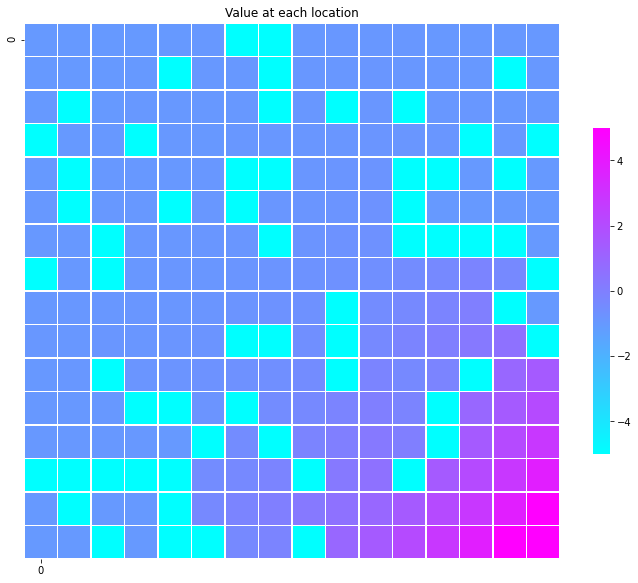

In [26]:

x = V.reshape(16, 16)
f, ax = plt.subplots(figsize=(12, 12))
cmap=seaborn.diverging_palette(0, 200, s=50, l=77,
                                  n=90, center="dark", as_cmap=True)
#cmap = seaborn.diverging_palette(220, 20, as_cmap=True)
ax = seaborn.heatmap(x, cmap='cool',square=True, xticklabels=16+1, yticklabels=16+1,
       linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.title('Value at each location')

In [27]:
s=[]
for i in range(100):
    _,_,t=policy_iteration1(env, gamma = gamma)
    s.append(t)

In [28]:
from scipy.stats import norm
s=np.array(s)
(mu, sigma) = norm.fit(s)
#formatted_mu = "{:.2f}".format(mu)
#formatted_sigma = "{:.2f}".format(sigma)
#print(['mu is {}' %mu, ' sigma is {}'%sigma])
print("mu is {:.5f}, sigma is {:.5f}".format(mu, sigma))

mu is 0.07337, sigma is 0.00497


Histogram of steps: μ=0.07337, sigma=0.00497


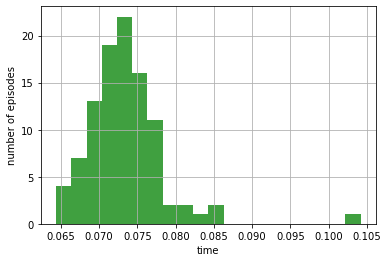

In [29]:
n, bins, patches = plt.hist(s, 20, density=0, facecolor='green', alpha=0.75)
plt.xlabel('time')
plt.ylabel('number of episodes')
#plt.title('Histogram of steps: μ=' + str(mu) + ' sigma=' + str(sigma))
print("Histogram of steps: μ={:.5f}, sigma={:.5f}".format(mu, sigma))
plt.grid(True)
plt.show()